# Exercise 1 -- The Dataset

The PTB Dataset is a collection of text snippets of stories from the Wall Street Journal. 
The data set divided into 3 datasets for training, validation and testing, respectively.
In this exercise we prepare the data for neural network training and inference.

## Downloading the dataset

We have downloaded the PTB training set from https://github.com/tomsercu/lstm/tree/master/data and put the files `train.txt`, `test.txt` and `valid.txt` into the subfolder `ptb_data/`.

## Some sample phrases

Let's print some examples of phrases, which occur in the data set:

In [1]:
print_lines = (7, 34, 67, 93, 114)      # randomly chosen integers
with open('ptb_data/train.txt') as fh:
    for il, line in enumerate(fh):
        if il in print_lines:
            print('Line %i:\n"%s"\n' %(il, line))

Line 7:
" although preliminary findings were reported more than a year ago the latest results appear in today 's new england journal of medicine a forum likely to bring new attention to the problem 
"

Line 34:
" yields on money-market mutual funds continued to slide amid signs that portfolio managers expect further declines in interest rates 
"

Line 67:
" in the new position he will oversee mazda 's u.s. sales service parts and marketing operations 
"

Line 93:
" south korea 's economic boom which began in N stopped this year because of prolonged labor disputes trade conflicts and sluggish exports 
"

Line 114:
" new england electric system bowed out of the bidding for public service co. of new hampshire saying that the risks were too high and the potential <unk> too far in the future to justify a higher offer 
"



We see that the text has been proprocessed as
- ... it contains the special term `<unk>` in place of rare words that do not occur frequently in the dataset
- ... there is no punctuation (exception in abbreviations)
- ... words are in lower case
- ... numbers have been replaced by "N"
- ... spaces have been included before some terms such as "’ll", "’s", "n’t"
Furthermore we can see that each line contains still the newline character `\n` and also an additional space in the front.

## Adding `<eos>`

In order to represent the text as arrays, we need to add one further preprocessing step: each newline character should be replaced with the special sequence `<eos>`. We do this for our example sentences below:

In [2]:
print_lines = (7, 34, 67, 93, 114)      # randomly chosen integers
with open('ptb_data/train.txt') as fh:
    for il, line in enumerate(fh):
        if il in print_lines:
            print('Line %i:\n"%s"\n' %(il, line.strip('\n') + '<eos>'))

Line 7:
" although preliminary findings were reported more than a year ago the latest results appear in today 's new england journal of medicine a forum likely to bring new attention to the problem <eos>"

Line 34:
" yields on money-market mutual funds continued to slide amid signs that portfolio managers expect further declines in interest rates <eos>"

Line 67:
" in the new position he will oversee mazda 's u.s. sales service parts and marketing operations <eos>"

Line 93:
" south korea 's economic boom which began in N stopped this year because of prolonged labor disputes trade conflicts and sluggish exports <eos>"

Line 114:
" new england electric system bowed out of the bidding for public service co. of new hampshire saying that the risks were too high and the potential <unk> too far in the future to justify a higher offer <eos>"



## Assessing the size of the splits

Here we count the number of words in each of the splits of the training data. For that puropose we define a function, which performs the word counting for us:

In [3]:
def count_words(fname):
    tmp = []
    with open(fname) as fh:
        for line in fh:
            tmp2 = line.strip().split() + ['<eos>']
            for el in tmp2:
                tmp.append(line)
    return len(tmp)

Now we can easily determine the number of words in each of the splits of the PTB data:

In [4]:
print('The training data contains:', count_words('ptb_data/train.txt'), 'words')
print('The validation data contains:', count_words('ptb_data/valid.txt'), 'words')
print('The test data contains:', count_words('ptb_data/test.txt'), 'words')

The training data contains: 929589 words
The validation data contains: 73760 words
The test data contains: 82430 words


## Building a dictionary

Here we take the example code from https://github.com/pytorch/examples/blob/main/word_language_model/data.py as our data loading routine as it implements everything we need. It includes a dictionary of the words in the data.

In [5]:
from corpus import Corpus
corpus = Corpus('ptb_data')
len(corpus.dictionary)

10000

We see that there are in total 10000 unique words in the dataset. The `Corpus` class contains a dictionary as class attribute, which in turn contains the assignment of an unique integer label to each unique word. As an illustration we print every 1000th word in the dictionary:

In [6]:
words = corpus.dictionary.idx2word[::1000]
print(words)

['aer', 'dec.', 'polled', 'furniture', 'sort', 'root', 'geneva', 'tale', 'interpreted', 'gte']


Furthermore the `Corpus` class contains also a lookup table of which word corresponds to which integer label. We illustrate this by printing the integers corresponding ot the words in the variable `words` assigned above:

In [7]:
tmpstr = []
for word in words:
    tmpstr.append(corpus.dictionary.word2idx[word])
print(tmpstr)

[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]


With these preparations we are ready to embark on the task of training a Elman RNN on the data.

# Exercise 2 -- Training and evaluating the Elman recurrent neural network model

We now assemble and train an Elman recurrent neural network (RNN). Given a series of inputs $\mathbf{x} = (x_1, x_2, \ldots, x_{t-1}, x_{t}, x_{t+1}, \ldots, x_{l_{\mathrm{seq}}})$, the Elman RNN can be recursively defined via the relations

$$f(h_{t-1}, x_t) = \sigma(W_h h_{t-1} + W_{x} x_t + b_h)$$

and

$$g(h_t) = \sigma(W_y h_t + b_y)$$

where $h_{t}$ is the so-called *hidden state* at time $t$. Furthermore $W_h$, $W_{x}$, $W_{y}$, $b_h$ and $b_y$ are the learnable weights and biases of linear neural networks used in the hidden state propagation (function $f$) and prediction of output at time $t$ (function $g$). $\sigma$ is a non-linearity, commonly a $\tanh$ or $\mathrm{RELU}$ function. The image below visualizes how the the output of the RNN at time $t$ is given as a function of the input $x_t$ and the hidden state $h_t$ at time $t$. The hidden state encodes thereby the *history* or sequence of previous inputs.

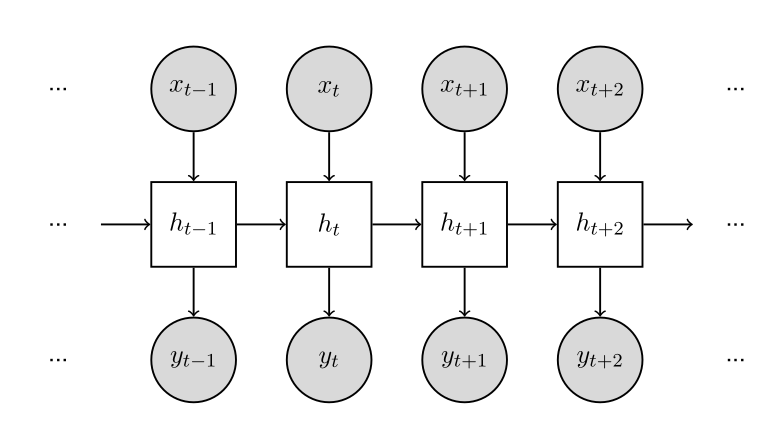

In [8]:
from PIL import Image
pil_im = Image.open('RNN_scheme.png')
display(pil_im)

## Implementing the Elman RNN

We have implemented the network described above using pytorch. We thereby leverage the implementations of the RNN layer in pytorch, `torch.nn.RNN()` (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) and the embedding layer `torch.nn.Embedding()` (https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html). We implement a custom model class `MyNetwork()` and the details of the implementation can be seen in the code snippet below.


In [9]:
from IPython.display import Code
Code(filename='mymodel.py', language='python')

import torch
import torch.nn as nn
import torch.nn.functional as F


# Define the Elman network class
class MyNetwork(nn.Module):
    def __init__(self, embedding_dim=100, hidden_size=100, nlayers=1, vocab_size=10000, rnn_type='RNN'):
        super(MyNetwork, self).__init__()
        
        # Define the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Define the RNN layer
        if rnn_type == 'RNN':
            # standard Elman RNN
            self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers=nlayers)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers=nlayers)
        else:
            raise NotImplementedError()
        
        # Define the output layer
        self.output_layer = nn.Linear(hidden_size, vocab_size)

        self.hidden_size = hidden_size
        self.nlayers = nlayers
        self.vocab_size = vocab_size
        self.rnn_type = rnn_type
        self.epoch = 0
        self.time = 0
        self.train_loss = []
        self.val_loss = []
    
    
    def forward(self, input, hidden=None):
        # Apply word embedding to input
        embedded = self.embedding(input)

        # Forward pass through the RNN layer
        if hidden is not None:
            output, hidden = self.rnn(embedded, hidden)
        else:
            output, hidden = self.rnn(embedded)

        # Apply the output layer and return the output
        output = self.output_layer(output).view(-1, self.vocab_size)
        
        return output, hidden
    
    
    def init_hidden(self, batch_size, method='zeros'):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            if method == 'zeros':
                return (weight.new_zeros(self.nlayers, batch_size, self.hidden_size),
                        weight.new_zeros(self.nlayers, batch_size, self.hidden_size))
            elif method == 'uniform':
                return (weight.uniform(self.nlayers, batch_size, self.hidden_size),
                        weight.uniform(self.nlayers, batch_size, self.hidden_size))
            else:
                raise NotImplementedError()
        else:
            if method == 'zeros':
                return weight.new_zeros(self.nlayers, batch_size, self.hidden_size)
            elif method == 'uniform':
                return weight.uniform(self.nlayers, batch_size, self.hidden_size)
            else:
                raise NotImplementedError()

We initialize the network using the code snippet below and use our gpu.

In [10]:
import torch
from mymodel import MyNetwork
device = torch.device("cuda")
model = MyNetwork().to(device)

## Implementing a data loading routine

Before we can train the network, we need to come up with a dataloading routine. The goal is to split the whole sequence of integers representing the entire text string of the dataset into $l_{\mathrm{seq}}$ sequences, of which $b$ are loaded at each training iteration. We follow here the implementation of this strategy as in the `main.py` script of the pytorch word language model example found at

https://github.com/pytorch/examples/tree/main/word_language_model

rather than a straightforward implementation of the ideas laid out in the instructions, since the strategy used in the pytorhc example leads to lower resource consumption. We start by loading the text using the routine we have developed in exercise 1 and choosing some batch size $b$ and sequence length $l_{\mathrm{seq}}$.

In [11]:
corpus = Corpus('ptb_data')
batch_size = 100
l_seq = 20

Next we divide each of the data sets into $b$ sequences using the `batchify()` function of the pytorch language model example.

In [12]:
def batchify(data, bsz):
    """ Credit for this function:
        https://github.com/pytorch/examples/blob/main/word_language_model/main.py
    """
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, batch_size)
test_data = batchify(corpus.test, batch_size)

Let's check the shape of the tensor containing the training data and also compare the first few rows and coulmns to the training data in the original `corpus.train`.

In [13]:
print(train_data.shape)
print(train_data[:10,:3])

# This is the first colum of train_data[:10,:3]
print(corpus.train[:10])
# This is the second colum of train_data[:10,:3]
print(corpus.train[train_data.shape[0]:train_data.shape[0]+10])
# This is the third colum of train_data[:10,:3]
print(corpus.train[2*train_data.shape[0]:2*train_data.shape[0]+10])

torch.Size([9295, 100])
tensor([[   0,  467,   48],
        [   1,  160,  166],
        [   2, 1112, 3174],
        [   3,  566, 3161],
        [   4,  749,  498],
        [   5,   93, 2970],
        [   6, 1123,  181],
        [   7,   24, 2587],
        [   8, 2006,   34],
        [   9, 1752,  250]], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([ 467,  160, 1112,  566,  749,   93, 1123,   24, 2006, 1752])
tensor([  48,  166, 3174, 3161,  498, 2970,  181, 2587,   34,  250])


We see that we have split the data into $b$ sequences and stored them in a tensor. In a next step we will need to further split these sequences into sequences of size $l_{\mathrm{seq}}$. To that end we follow the same strategy as in the pytorch example and define another function, which will return $b$ sequences of length $l_{\mathrm{seq}}$ starting with a specified index $i$. The function returns furthermore the input data to the RNN as well as the correct labels (targets).

In [14]:
def get_batch(source, i):
    seq_len = min(l_seq, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

We check the output of this function and note that the targets are given as a flattened array, which is the reason, why we return a view `.view(-1, self.vocab_size)` of the output in our model in `mymodel.py`.

In [15]:
data, targets = get_batch(train_data, 0)
print(data.shape)
print(targets.shape)
print(data[:10,:3])
print(targets[:10])

torch.Size([20, 100])
torch.Size([2000])
tensor([[   0,  467,   48],
        [   1,  160,  166],
        [   2, 1112, 3174],
        [   3,  566, 3161],
        [   4,  749,  498],
        [   5,   93, 2970],
        [   6, 1123,  181],
        [   7,   24, 2587],
        [   8, 2006,   34],
        [   9, 1752,  250]], device='cuda:0')
tensor([   1,  160,  166,  160,   34,  152, 2679, 5910,   26,  114],
       device='cuda:0')


With this data loading strategy implemented, the core of the training loop will be:
```
for batch, i in enumerate(range(0, train_data.size(0) - 1, l_seq)):
    data, targets = get_batch(train_data, i)
    ...
```
i.e., in each iteration, we will load $b$ sequences of length $l_{\mathrm{seq}}$, which are mutually non-overlapping. This strategy is thus equivalent to a naive implementation of the ideas given in the instructions.

## Training the Elman RNN

We are now ready to train the network. We use the pytorch function `CrossEntropyLoss()` as a loss function and the standard stochastic gradient descent optimizer `SGD()`.

In [16]:
import torch.optim as optim
lr = 1
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)

Next we write out the training loop, which performs one epoch of training. Based on our observations before, it is pretty straightforward to write up.

In [17]:
import time
import math
def train():
    model.train()
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, l_seq)):
        data, targets = get_batch(train_data, i)
        
        optimizer.zero_grad()
        
        output, hidden = model(data)
        loss = loss_fn(output, targets)
        loss.backward()
        
        optimizer.step()
    
    model.epoch += 1

We also need a function to evaluate the performance of our model. To that end, we reuse the function `evaluate()` from the pytorch language model example in the code below:

In [18]:
def evaluate(data_source):
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    
    hidden = model.init_hidden(batch_size)
    
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, l_seq):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data)
            total_loss += len(data) * loss_fn(output, targets).item()
    return total_loss / (len(data_source) - 1)

Furthermore we also create a convenience function `train_nepochs()`, which performs the training of the RNN for a certain number of epochs.

In [19]:
def train_nepochs(nepochs, fname, fname_best):

    # Loop over epochs
    for epoch in range(1, nepochs+1):
        
        epoch_start_time = time.time()
        train()
        
        model.train_loss.append(evaluate(train_data))
        model.val_loss.append(evaluate(val_data))
        
        time_epoch = time.time() - epoch_start_time
        model.time += time_epoch
        
        print('|          {:3d} |   {:9.1f}s |   {:5.2f} |   {:5.2f} |    {:8.2f} |    {:8.2f} |'\
              .format(model.epoch, time_epoch, model.train_loss[-1], model.val_loss[-1], 
                  math.exp(model.train_loss[-1]), math.exp(model.val_loss[-1])))
        print('-' * 78)
        
        # Save the model if the validation loss is the best we've seen so far.
        if len(model.val_loss) == 1 or model.val_loss[-1] < min(model.val_loss[:-1]):
            with open(fname_best, 'wb') as f:
                torch.save(model, f)
        
        with open(fname, 'wb') as f:
            torch.save(model, f)

Finally we can execute the whole training scheme and loop over epochs.

In [20]:
from fcns import print_log_head, load_model
from os.path import exists

fname = 'exercise2.torch'
fname_best = 'exercise2_best.torch'

if not exists(fname):
    nepochs = 100
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

------------------------------------------------------------------------------
|              |             |       loss        |        perplexity         |
| end of epoch |     time    |-------------------|---------------------------|
|              |             |  train  |  valid  |    train    |    valid    |
------------------------------------------------------------------------------
------------------------------------------------------------------------------
|          100 |      2666.0s |    4.77 |    5.25 |      117.87 |      190.88 |
------------------------------------------------------------------------------


We plot now the loss of the model on the training data and the validation data in the figure below. Note how the training loss improves much more during training than the validation loss, indicating a certain amount of overfitting to the training data. Despite of this the validation loss still continued to improve as a function of elapsed epoch until about epoch 33 for which we observed the smallest loss on the validation data. Furthermore we observe two large spikes in the training and validation loss, which are signatures of the *exploding gradient problem* in training RNNs.

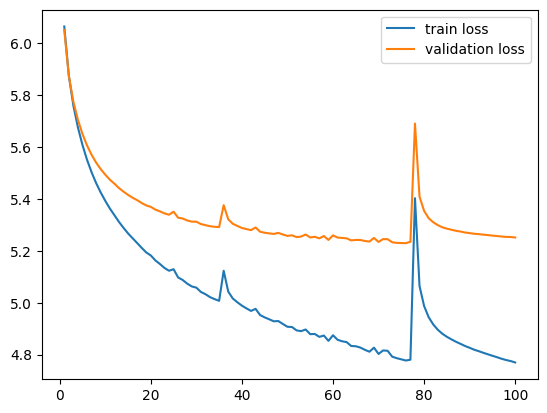

In [21]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), model.train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), model.val_loss, label='validation loss')
ax.legend()

## Evaluating the best obtained model

We will now evaluate the best model we have obtained. This is easily achieved by just loading the saved model from disk and running it on the test data.

In [22]:
model = torch.load(fname_best)
print('Best model obtained in epoch                  ', model.epoch)
test_loss = evaluate(val_data)
print('The perpelexity in the validation set is {:8.2f}'.format(math.exp(test_loss)))
test_loss = evaluate(test_data)
print('The perpelexity in the test set is       {:8.2f}'.format(math.exp(test_loss)))

Best model obtained in epoch                   76
The perpelexity in the validation set is   191.84
The perpelexity in the test set is         179.94


The best model was obtained after 76 epochs, indicating a rather slow and ineffiecient learning. We see that this preplexity is much larger than the perplexity obtained by state-of-the-art language models (c.f. https://paperswithcode.com/sota/language-modelling-on-penn-treebank-word), but that is not so surprising as we use a very simple model here with no optimizations. It is interesting to note that the performance on the test data was better than on the validation data, which could be an indication that the test data is more similar to the training data set than the validation data is. We will see in exercise 3 how we can improve the model performance.

## Generating sample phrases

We now use our Elman RNN to generate some sample phrases. We implement here two of the methods described in the instructions, namely the *greedy* and *sampling* methods. Using the *greedy* method, the output is taken to be the output with the largest likelihood over all classes. In the *sampling* method on the other hand, the output is determined with a certain probability, taken to be the probability for the word predicted by the RNN. The code for these samling methods is printed below:

In [23]:
import numpy as np
import torch.nn.functional as F
def generate_sample_phrase(seed_phrase, ngen, method='sample'):
    model.eval()
    hidden = model.init_hidden(1)
    
    for word in seed_phrase.split():
        inp = torch.tensor(corpus.dictionary.word2idx[word]).to(device).view(-1,1)
        output, hidden = model(inp, hidden)
    
    out_phrase = seed_phrase
    for i in range(ngen):
        P = F.softmax(output, dim=1).cpu().detach().numpy().reshape(-1)
                
        if method == 'sample':
            new_idx = np.random.choice(np.arange(1, 10001), 1, p=P)[0]
        elif method == 'greedy':
            new_idx = np.argmax(P)
        else:
            raise NotImplementedError('')
        
        new_word = corpus.dictionary.idx2word[new_idx]
        
        out_phrase += f' {new_word}'
        
        inp = torch.tensor(new_idx).to(device).view(-1,1)
        output, hidden = model(inp, hidden)
    
    return out_phrase

We generate now two phrases using the *sampling* method. We see that the two phrases differ as we expect from a probabilistic method. Thehis indicates that we need to refine and improve our model more.

In [24]:
print(generate_sample_phrase('i have to', 10, method='sample'))
print(generate_sample_phrase('i have to', 10, method='sample'))

print(generate_sample_phrase('the house is', 10, method='sample'))
print(generate_sample_phrase('the house is', 10, method='sample'))

i have to added maturities make describes pierre researchers its booked smokers norman
i have to besides link make order expected make few restructured board historically
the house is negotiate show its estate traveling permit decision smokers pierre inc.
the house is sorrell classified heavy smokers skiing stop relying view egyptian N


Next we also use the *greedy* method to generate example phrases. Two phrases for the same input sequence do not differ, since the network predicts the same maximum probabilities in the two runs as one would expect. Furthermore one can see that there seems to be a tendency for the *greedy* method to get stuck in a loop of repeating the same words, which are ubiquitous in the data set and in the english language. Furthermore the sequences `<unk>` and `<eos>` probably appear semi-randomly in the data and have rather high probabilities to appear anywhere.

In [25]:
print(generate_sample_phrase('i have to', 10, method='greedy'))
print(generate_sample_phrase('i have to', 10, method='greedy'))

print(generate_sample_phrase('the house is', 10, method='greedy'))
print(generate_sample_phrase('the house is', 10, method='greedy'))

i have to be <unk> <eos> the <unk> of the <unk> of the
i have to be <unk> <eos> the <unk> of the <unk> of the
the house is a <unk> <unk> <eos> the <unk> of the <unk> of
the house is a <unk> <unk> <eos> the <unk> of the <unk> of


# Exercise 3 -- Improving the recurrent model

In this exercise we will try different ways to improve the performance of the RNN model on the PTB data set.

## Gradient clipping

As a first step, we consider the effect of gradient clipping. Gradient clipping reduces the maximum magnitude of the gradient during parameter update to a selectable value $M$. In other words during gradient descent, new parameters $\theta_k$ are determined by applying
$$
\theta_k = \theta_{k-1} - \gamma \nabla J(\theta_{k-1})
$$
where $\nabla J(\theta_{k-1})$ is the gradient and $\gamma$ the learning rate. Gradient clipping then corresponds to introduction of a function
$$
clip_M(\theta) = 
\begin{cases}
\theta & \mathrm{if} ||\theta|| \leq M \\
M \frac{\theta}{||\theta||} \qquad & \mathrm{if} ||\theta|| \leq M
\end{cases}
$$
which is applied during parameter update as follows:
$$
\theta_k = \theta_{k-1} - \gamma clip_M(\theta)(\nabla J(\theta_{k-1})).
$$
We set our model and training loops up as in exercise 2, but use the gradient clipping routine `clip_grad_norm_()` provided by pytorch in the `train()` function and also increase the learning rate as that should be safely possible with gradient clipping. 

In [26]:
import time
import math

def train():
    model.train()
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, l_seq)):
        data, targets = get_batch(train_data, i, l_seq)
        
        optimizer.zero_grad()
        
        output, hidden = model(data)
        loss = loss_fn(output, targets)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    
    model.epoch += 1

With everything in place, we can proceed with the training of our model:

In [27]:
nepochs = 50
clip = .25
fname = 'exercise3_gc.torch'
fname_best = 'exercise3_gc_best.torch'

from fcns import print_log_head, load_model
from os.path import exists

if not exists(fname):
    model = MyNetwork().to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

------------------------------------------------------------------------------
|              |             |       loss        |        perplexity         |
| end of epoch |     time    |-------------------|---------------------------|
|              |             |  train  |  valid  |    train    |    valid    |
------------------------------------------------------------------------------
------------------------------------------------------------------------------
|           50 |      1326.4s |    4.57 |    5.34 |       96.87 |      209.00 |
------------------------------------------------------------------------------


We plot now the training and validation loss of the model in the figure below. Compared to the loss obtained in exercise 2, we find that the loss is a lot smoother as a function of epoch due to the effect of the gradient clipping. This indicates also, that the spikeyness observed in connection with exercise 2 is related to the *exploding gradient* problem in RNNs. Furthermore we observe a tendency to overfit to the training data from about epoch 5 onwards. Despite this the validation loss continues to improve until about epoch 30.

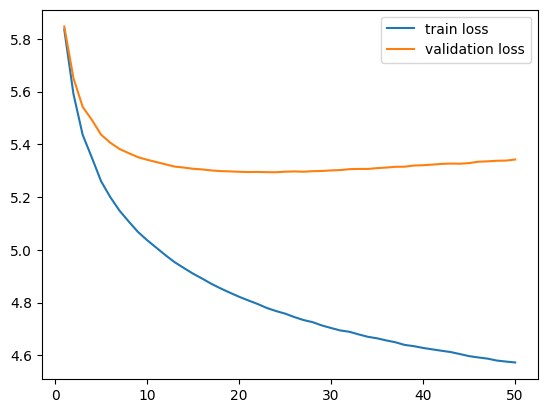

In [28]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), model.train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), model.val_loss, label='validation loss')
ax.legend()

As a last performance metric for the evaluation of gradient clipping, we compute the perplexity of the best obtained model on the test data.

In [29]:
model = torch.load(fname_best)
test_loss = evaluate(val_data)
print('Best model obtained in epoch                  ', model.epoch)
print('The perpelexity in the validation set is {:8.2f}'.format(math.exp(test_loss)))
test_loss = evaluate(test_data)
print('The perpelexity in the test set is       {:8.2f}'.format(math.exp(test_loss)))

Best model obtained in epoch                   24
The perpelexity in the validation set is   204.37
The perpelexity in the test set is         192.71


The best loss was obtained after 24 epochs of training, showing that the higher learning rate enabled by gradient clipping allowed us to train our model faster and more efficiently. In comparison with the performance observed in exercise 2, we get here slightly worse performance, which is likely connected to the 5 times larger learning rate and a smaller learning rate would probably allow for better performance of the model. We will explore the effect of a learning rate scheduler further below.

## Improving the flow of information

In order to improve the flow of information, we pass the hidden state on to the next training iteration. This is simply achieved by adding the hidden state to the inputs of the `model()` call. However we also need to prevent the model from backpropagating through the training iterations. We achieve this by wrapping the hidden state tensor into a new tensor, which is detached from its "history" in each iteration of the training loop. The following code snippets show the approach.

We first define a function to detach the hidden state from backpropagation.

In [30]:
from fcns import repackage_hidden
from IPython.display import Code
Code(data=''.join([line for line in open('fcns.py')][34:42]), language='python')

def repackage_hidden(h):
    """ Credit for this function:
        https://github.com/pytorch/examples/blob/main/word_language_model/main.py
    """
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

Next we update the `forward()` function of our model to include the hidden state passing.

In [31]:
Code(data=''.join([line for line in open('mymodel.py')][35:45]), language='python')

def forward(self, input, hidden=None):
        # Apply word embedding to input
        embedded = self.embedding(input)

        # Forward pass through the RNN layer
        if hidden is not None:
            output, hidden = self.rnn(embedded, hidden)
        else:
            output, hidden = self.rnn(embedded)

We the need to modify the call to `model()` and use our new function `repackage_hidden()` to detach the hidden stat in each iteration.

In [32]:
import time
import math

def train():
    model.train()
    hidden = model.init_hidden(batch_size)
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, l_seq)):
        data, targets = get_batch(train_data, i, l_seq)
        
        optimizer.zero_grad()
        hidden = repackage_hidden(hidden)
        output, hidden = model(data, hidden)
        loss = loss_fn(output, targets)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    
    model.epoch += 1

Similarly we modify the `evaluate()`function to also pass the hidden state to the model and detach the hidden state:

In [33]:
def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    
    hidden = model.init_hidden(batch_size)
    
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, l_seq):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            hidden = repackage_hidden(hidden)
            total_loss += len(data) * loss_fn(output, targets).item()
    return total_loss / (len(data_source) - 1)

With all code modifications in place, we can now train our model with improved information flow.

In [34]:
# Loop over epochs.
best_val_loss = None
fname = 'exercise3_iif.torch'
fname_best = 'exercise3_iif_best.torch'

from fcns import print_log_head, load_model
from os.path import exists

if not exists(fname):
    model = MyNetwork().to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

------------------------------------------------------------------------------
|              |             |       loss        |        perplexity         |
| end of epoch |     time    |-------------------|---------------------------|
|              |             |  train  |  valid  |    train    |    valid    |
------------------------------------------------------------------------------
------------------------------------------------------------------------------
|           50 |      1322.0s |    4.55 |    5.31 |       94.87 |      202.31 |
------------------------------------------------------------------------------


We plot the train and validation loss as a function of epoch below. Overall the loss looks very similar to the previous part, where we introduced gradient clipping. 

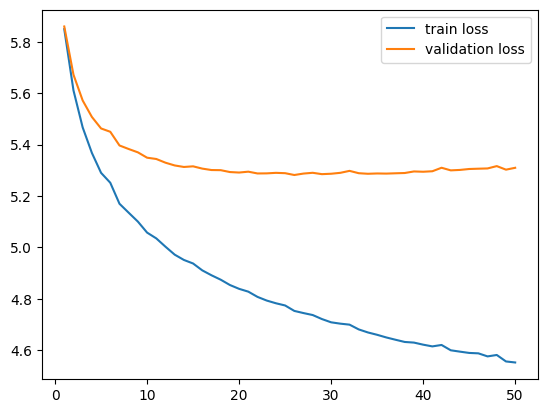

In [35]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), model.train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), model.val_loss, label='validation loss')
ax.legend()

The best loss was obtained after 26 epochs of training and we achieved slightly better performance without modifying the learning rate compared to the previous section, but still not as good as we observed in exercise 2. This shows that improving the information flow by passing the hidden state does not just straight-up improve the RNN by enabling to learn longer term dependencies, but the RNN must also be able to learn these long-term dependencies, which is sensitively dependent on other design- and hyper-parameters.

In [36]:
model = torch.load(fname_best)
test_loss = evaluate(val_data)
print('Best model obtained in epoch                  ', model.epoch)
print('The perpelexity in the validation set is {:8.2f}'.format(math.exp(test_loss)))
test_loss = evaluate(test_data)
print('The perpelexity in the test set is       {:8.2f}'.format(math.exp(test_loss)))

Best model obtained in epoch                   26
The perpelexity in the validation set is   196.72
The perpelexity in the test set is         187.00


## Gated units

We now replace the Elman RNN by the LSTM. This is easily done using pytorch's `LSTM()` layer. We have followed the ideas outlined in https://github.com/pytorch/examples/blob/main/word_language_model/main.py and included an argument `rnn_type` in the definition of the `MyNetwork()` class, which allows to switch over from the Elman RNN to the LSTM unit.

In [37]:
model = MyNetwork(rnn_type='LSTM').to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)

In [38]:
fname = 'exercise3_lstm.torch'
fname_best = 'exercise3_lstm_best.torch'

if not exists(fname):
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

------------------------------------------------------------------------------
|              |             |       loss        |        perplexity         |
| end of epoch |     time    |-------------------|---------------------------|
|              |             |  train  |  valid  |    train    |    valid    |
------------------------------------------------------------------------------
------------------------------------------------------------------------------
|           50 |      1498.2s |    4.31 |    5.14 |       74.41 |      171.24 |
------------------------------------------------------------------------------


We observe that the loss in the LSTM is a lot smoother as a function of epoch than what we have obtained thus far for the Elman RNN, suggesting that the LSTM is a bit easier to train. We observe quite some overfitting to the training data from about epoch 27 onwards.

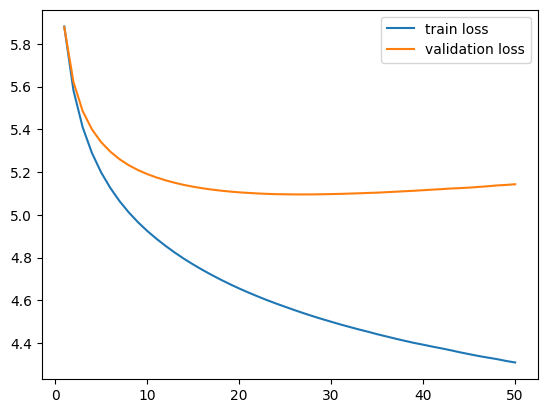

In [39]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), model.train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), model.val_loss, label='validation loss')
ax.legend()

The best model was obtained after 27 epochs of training. It performs much better than the Elman RNN judging from the perplexity scores. We continue to see the trend, that the perplexity on the validation data is worse than it is on the test data.

In [40]:
model = torch.load(fname_best)
test_loss = evaluate(val_data)
print('Best model obtained in epoch                  ', model.epoch)
print('The perpelexity in the validation set is {:8.2f}'.format(math.exp(test_loss)))
test_loss = evaluate(test_data)
print('The perpelexity in the test set is       {:8.2f}'.format(math.exp(test_loss)))

Best model obtained in epoch                   27
The perpelexity in the validation set is   163.27
The perpelexity in the test set is         154.51


## Improving the model further

As a last part of this assignment we consider further improvements to the model.

### Increasing the number of layers

First we will increase the number of layers to increase the expressiveness of the model.

In [41]:
fname = 'exercise3_lnl.torch'
fname_best = 'exercise3_lnl_best.torch'

if not exists(fname):
    model = MyNetwork(rnn_type='LSTM', nlayers=2).to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

------------------------------------------------------------------------------
|              |             |       loss        |        perplexity         |
| end of epoch |     time    |-------------------|---------------------------|
|              |             |  train  |  valid  |    train    |    valid    |
------------------------------------------------------------------------------
------------------------------------------------------------------------------
|           50 |      1708.6s |    4.25 |    5.12 |       69.98 |      166.55 |
------------------------------------------------------------------------------


The loss as a function of epoch continues to look similar to the other loss curves we have observed thus far. There is a strong overfitting to the training data present after about epoch 20.

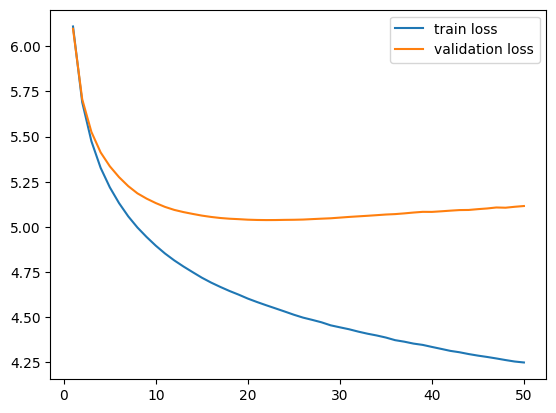

In [42]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), model.train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), model.val_loss, label='validation loss')
ax.legend()

The best model was now obtained after 22 epochs of training and it performed a bit better than the model considering only one layer., suggesting that the model is able to learn more of the patterns inherent to the data set.

In [43]:
model = torch.load(fname_best)
test_loss = evaluate(val_data)
print('Best model obtained in epoch                  ', model.epoch)
print('The perpelexity in the validation set is {:8.2f}'.format(math.exp(test_loss)))
test_loss = evaluate(test_data)
print('The perpelexity in the test set is       {:8.2f}'.format(math.exp(test_loss)))

Best model obtained in epoch                   22
The perpelexity in the validation set is   154.07
The perpelexity in the test set is         147.82


### Use a learning rate scheduler

As a second improvement we consider the effect of introducing a learning rate scheduler. To that end we modify the code in the `train_nepochs()` function to include the scheduler code. We use here the pytorch `torch.optim.lr_scheduler.ReduceLROnPlateau` scheduler, which reduces the learning rate after a selectable period of no improvements in the loss.

In [44]:
def train_nepochs(nepochs, fname, fname_best):
    
    for epoch in range(1, nepochs+1):
        
        epoch_start_time = time.time()
        train()
        
        model.train_loss.append(evaluate(train_data))
        model.val_loss.append(evaluate(val_data))

        scheduler.step(model.val_loss[-1])
        
        time_epoch = time.time() - epoch_start_time
        model.time += time_epoch
        
        print('|          {:3d} |   {:9.1f}s |   {:5.2f} |   {:5.2f} |    {:8.2f} |    {:8.2f} |'\
              .format(model.epoch, time_epoch, model.train_loss[-1], model.val_loss[-1], 
                  math.exp(model.train_loss[-1]), math.exp(model.val_loss[-1])))
        print('-' * 78)
        
        # Save the model if the validation loss is the best we've seen so far.
        if len(model.val_loss) == 1 or model.val_loss[-1] < min(model.val_loss[:-1]):
            with open(fname_best, 'wb') as f:
                torch.save(model, f)
        
        with open(fname, 'wb') as f:
            torch.save(model, f)

We train the network starting with the same parameters as before. The learning rate scheduler should reduce the learning rate step by step as we approch the minimum of the loss.

In [45]:
fname = 'exercise3_lrsched.torch'
fname_best = 'exercise3_lrsched_best.torch'

if not exists(fname):
    model = MyNetwork(rnn_type='LSTM', nlayers=2).to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

------------------------------------------------------------------------------
|              |             |       loss        |        perplexity         |
| end of epoch |     time    |-------------------|---------------------------|
|              |             |  train  |  valid  |    train    |    valid    |
------------------------------------------------------------------------------
------------------------------------------------------------------------------
|           50 |      1778.5s |    4.32 |    5.03 |       74.89 |      152.34 |
------------------------------------------------------------------------------


Using the learning rate scheduler we obtain a loss curve, which flattens out after about 35 epochs of training. There is quite a clear evidence of the learning rate scheduler adjusting the learning rate as we observe some jumps in the learning rate. A strong overfitting on the training set continues to be present.

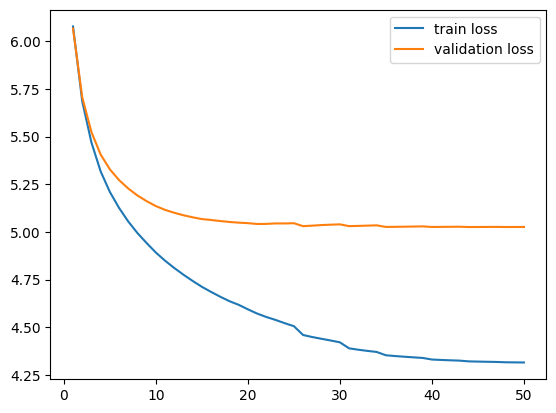

In [46]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), model.train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), model.val_loss, label='validation loss')
ax.legend()

With the 2 layers in the LSTM network and using a learning rate shceduler we reach an improved perplexity rating of 146.25 on the test set:

In [47]:
model = torch.load(fname_best)
test_loss = evaluate(val_data)
print('Best model obtained in epoch                  ', model.epoch)
print('The perpelexity in the validation set is {:8.2f}'.format(math.exp(test_loss)))
test_loss = evaluate(test_data)
print('The perpelexity in the test set is       {:8.2f}'.format(math.exp(test_loss)))

Best model obtained in epoch                   44
The perpelexity in the validation set is   152.29
The perpelexity in the test set is         146.25
